In [1]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import ResNet50,ResNet101,ResNet152,DenseNet169,ResNet152
print("Tensorflow version " + tf.__version__)


2022-10-14 23:14:25.861638: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-14 23:14:25.861797: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# Configurations

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
IMAGE_SIZE = [224, 224]
EPOCHS = 60
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

2022-10-14 23:14:31.848609: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-14 23:14:31.851409: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-14 23:14:31.851452: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-14 23:14:31.851483: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c9a0b2344bd5): /proc/driver/nvidia/version does not exist
2022-10-14 23:14:31.854397: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [3]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

2022-10-14 23:14:38.310767: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-14 23:14:38.396597: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-10-14 23:14:38.470004: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Unhide to see `CLASSES`:

In [4]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Helper Functions
## Visualization

In [5]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## Datasets Functions

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label, seed=2020):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image, seed=seed)
#     image = tf.image.random_flip_up_down(image, seed=seed)
#     image = tf.image.random_brightness(image, 0.1, seed=seed)
    
#     image = tf.image.random_jpeg_quality(image, 85, 100, seed=seed)
#     image = tf.image.resize(image, [530, 530])
#     image = tf.image.random_crop(image, [512, 512], seed=seed)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_train_valid_datasets():
    dataset = load_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


# Training Model

## Load Model into TPU

In [7]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [8]:
def freeze(model):
    for layer in model.layers:
        layer.trainable = False

def unfreeze(model):
    for layer in model.layers:
        layer.trainable = True

In [9]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE
STEPS_PER_EPOCH1 = (NUM_TRAINING_IMAGES) // BATCH_SIZE
STEPS_PER_EPOCH2 = (NUM_VALIDATION_IMAGES) // BATCH_SIZE
print('Dataset: {} training images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES+NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16465 training images, 7382 unlabeled test images


In [10]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model,load_model
#from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Concatenate
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

def Conv2D_M_filters_id(X_1,F,conv_name_base,pad,strid):
    f1=int(F*0.85)
    f2=int(F*0.15)
    f3=0#int(F*0.05)
    remain=F-(f1+f2+f3)
    f1+=remain
    if pad=='same':
            #X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='same', name=conv_name_base +"2b2", kernel_initializer=glorot_uniform(seed=0))(X_1)
            X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='same', name=conv_name_base + '2b3', kernel_initializer=glorot_uniform(seed=0))(X_1)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='same', name=conv_name_base , kernel_initializer=glorot_uniform(seed=0))(X_1)  
    else:
        if strid==(1,1):
            #X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2', kernel_initializer=glorot_uniform(seed=0))(X_1)
            #X1=ZeroPadding2D(padding=2)(X1)
            X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3', kernel_initializer=glorot_uniform(seed=0))(X_1)
            X2=ZeroPadding2D(padding=1)(X2)
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base , kernel_initializer=glorot_uniform(seed=0))(X_1)
        else:
            #X1= Conv2D(filters=f3, kernel_size=(7, 7), strides=strid, padding='valid', name=conv_name_base + '2b2', kernel_initializer=glorot_uniform(seed=0))(X_1)
            #X1=ZeroPadding2D(padding=1)(X1)
            X2= Conv2D(filters=f2, kernel_size=(5, 5), strides=strid, padding='valid', name=conv_name_base + '2b3', kernel_initializer=glorot_uniform(seed=0))(X_1)
            X2=ZeroPadding2D(padding=((0, 1), (0, 1)))(X2)#((top_pad, bottom_pad), (left_pad, right_pad))
            X3= Conv2D(filters=f1, kernel_size=(3, 3), strides=strid, padding='valid', name=conv_name_base , kernel_initializer=glorot_uniform(seed=0))(X_1)


 
    X=Concatenate(axis=-1)([X2,X3])
    return X
def insert_layer_nonseq(model, position='replace'):
    filter_name={}
    padding={}
    names=[]
    strid_={}
    for i in model.layers: 
        layer_type = type(i).__name__
        if layer_type== 'Conv2D' and i.kernel_size == (3,3):
            filter_name[i.name]=i.filters
            padding[i.name]=i.padding
            names.append(i.name)
            strid_[i.name]=i.strides
      # Auxiliary dictionary to describe the network graph
        network_dict = {'input_layers_of': {}, 'new_output_tensor_of': {}}

    # Set the input layers of each layer
    for layer in model.layers:
        for node in layer._outbound_nodes:
            layer_name = node.outbound_layer.name
            if layer_name not in network_dict['input_layers_of']:
                network_dict['input_layers_of'].update(
                        {layer_name: [layer.name]})
            else:
                network_dict['input_layers_of'][layer_name].append(layer.name)

    # Set the output tensor of the input layer
    network_dict['new_output_tensor_of'].update(
            {model.layers[0].name: model.input})

    # Iterate over all layers after the input
    x = None
    for layer in model.layers[1:]:

        # Determine input tensors
        layer_input = [network_dict['new_output_tensor_of'][layer_aux] 
                for layer_aux in network_dict['input_layers_of'][layer.name]]
        if len(layer_input) == 1:
            layer_input = layer_input[0]

        # Insert layer if name matches the regular expression
        if  layer.name in names :
            if position == 'replace':
                x = layer_input
            elif position == 'after':
                x = layer(layer_input)
            elif position == 'before':
                pass
            else:
                raise ValueError('position must be: before, after or replace')
            print(layer.filters,layer.strides,layer.padding,layer.kernel_size)
            new_layer = Conv2D_M_filters_id(x,filter_name[layer.name],layer.name,pad=padding[layer.name],strid=strid_[layer.name])
            x = new_layer#(x)
            print('New layer: {} Old layer: {} Type: {}'.format(new_layer.name,
                                                            layer.name, position))
            if position == 'before':
                x = layer(x)
        else:
            x = layer(layer_input)

        # Set new output tensor (the original one, or the one of the inserted
        # layer)
        network_dict['new_output_tensor_of'].update({layer.name: x})

        # Save tensor in output list if it is output in initial model
        #if layer_name in model.output_names:
        #    model_outputs.append(x)

    return Model(inputs=model.inputs, outputs=x)

In [11]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    rnet = DenseNet169(
        input_shape=(224, 224, 3),
        weights=None,#'imagenet',
        include_top=False)
    #rnet.save_weights("we.h5")
    #rnet=insert_layer_nonseq(rnet)
    #rnet.load_weights("we.h5",by_name=True,skip_mismatch=True)
    model = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               173160    
Total params: 12,816,040
Trainable params: 12,657,640
Non-trainable params: 158,400
_________________________________________________________________


## Training

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)
checkpoint_path = './model.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(
    get_training_dataset(), 
    validation_data=get_validation_dataset(),
    steps_per_epoch=STEPS_PER_EPOCH1,
    validation_steps=STEPS_PER_EPOCH2,
    epochs=EPOCHS, 
    callbacks=[lr_schedule,model_checkpoint_callback]
)
model.load_weights(checkpoint_path)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
99/99 [==============================] - 145s 309ms/step - loss: 4.6384 - sparse_categorical_accuracy: 0.0319 - val_loss: 4.4978 - val_sparse_categorical_accuracy: 0.0582
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
99/99 [==============================] - 14s 144ms/step - loss: 3.5869 - sparse_categorical_accuracy: 0.1633 - val_loss: 5.4620 - val_sparse_categorical_accuracy: 0.0442
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
99/99 [==============================] - 14s 142ms/step - loss: 2.9917 - sparse_categorical_accuracy: 0.2552 - val_loss: 7.7464 - val_sparse_categorical_accuracy: 0.0523
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
99/99 [==============================] - 14s 143ms/step - loss: 2.6654 - sparse_categorical_accuracy: 0.3191 - val_loss: 7.2446 - val_sparse_categorical_accuracy

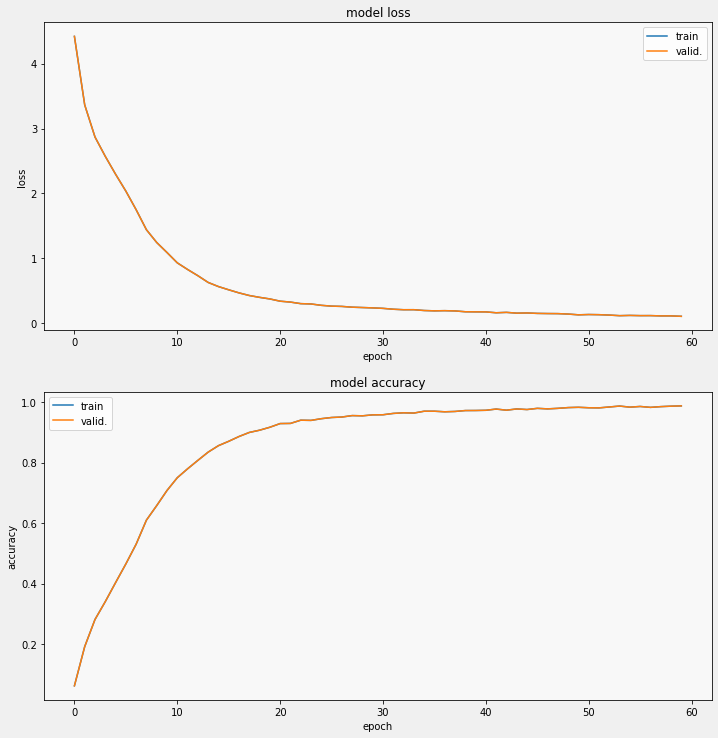

In [13]:
display_training_curves(history.history['loss'], history.history['loss'], 'loss', 211)
display_training_curves(history.history['sparse_categorical_accuracy'], history.history['sparse_categorical_accuracy'], 'accuracy', 212)

# Predictions

In [14]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')

Computing predictions...
[67 28 83 ... 28 53 53]
Generating submission.csv file...


2022-10-14 23:33:42.815182: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 266982, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1665790422.811651353","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 266982, Output num: 0","grpc_status":3}
